# EDA

#### A study of Asian Religious and Biblical Texts Data Set

Adrianna Grudzień, Mateusz Stączek

Data: [archive.ics.uci.edu](https://archive.ics.uci.edu/ml/datasets/A+study+of++Asian+Religious+and+Biblical+Texts)

Tutorials about NLP EDA: [neptune.ai/blog](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools), [towardsdatascience.com](https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d)

Related article: [www.researchgate.net](https://www.researchgate.net/publication/338137955_What_do_Asian_Religions_Have_in_Common_An_Unsupervised_Text_Analytics_Exploration)

### Introduction

In this task, there are 8 religious texts, 4 from Asia, 4 Biblical:

- Upanishads, 
- Yoga Sutras, 
- Buddha Sutras, 
- Tao Te Ching, 
- Book of Wisdom, 
- Book of Proverbs, 
- Book of Ecclesiastes,
- Book of Ecclesiasticus.

Each text has been divided into chapters (590 chapters in total) and the goal will be to divide these chapters into clusters matching book of origin. This notebook is only the EDA of available data with no unsupervised models.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer, word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import pyLDAvis
import pyLDAvis.gensim_models

First, we have checked the provided pre-processed Bag of Words Document Term Matrix (one without labels), as seen below. There are 8266 columns, each presenting a different word. Each cell have the number of occurences of given word (column) in selected chapter (row).

In [ ]:
df_csv = pd.read_csv('AllBooks_baseline_DTM_Unlabelled.csv')
df_csv.head(2)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,# foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,convict,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_csv.shape

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(590, 8266)

The [related article](https://www.researchgate.net/publication/338137955_What_do_Asian_Religions_Have_in_Common_An_Unsupervised_Text_Analytics_Exploration) describes the preprocessing of raw txt data to achieve this matrix form. We could try to get the same results, however working with ancient English is not feasible due to modern libraries such as NLKT not supporting it. 

Just to give an example, word `you` and `thou` have the same meaning and both are present in the raw txt (`you` has 115 occurrences, `thou` has 449). Similarly, `your` and `thy` can be found 35 and 645 times respectively.

Results acquired from our preprocessing of raw txt may give different results than those based on the provided dataframe. The hint of differences is that in the preprocessed data words such as `you` and `your` are not present whereas `thou` and `thy` are.

## Reading raw txt

In [ ]:
with open('Complete_data.txt', 'r',encoding='latin-1') as file:
    txt = file.read()
chapters = re.split('\n\d\.\d+\n', txt)
chapters = [re.sub(r'\d\.\d+\n','',text) for text in chapters]
to_pop=[]
for i in range(len(chapters)):
    if chapters[i].strip()=='':
        to_pop.append(i)
for index in to_pop:
    chapters.pop(index)

print("Is the number of chapters correct?", len(chapters) == len(df_csv))

Is the number of chapters correct? True
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
<ipython-input-4-0f9785a031ec>:3: DeprecationWarning: invalid escape sequence \d
  chapters = re.split('\n\d\.\d+\n', txt)


##### An empty chapter?

Random discovery: chapter 14 of Buddha Sutras is empty in both txt and csv files. Why? We have no idea. Proof below.

In [ ]:
chapter_lengths = [len(x) for x in chapters]
min_chap_len = min(chapter_lengths)
shortest_chapter = chapter_lengths.index(min_chap_len)
print("Shortest chapter is", shortest_chapter+1) # counting starts from 0
print(f'It\'s content: "{chapters[shortest_chapter]}"')
print("Number of words in this chapter from provided dataframe", np.sum(df_csv.iloc[shortest_chapter, :]))

Shortest chapter is 14
It's content: "§ 14."
Number of words in this chapter from provided dataframe 0.0
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Some cleaning

Next, we deleted numbers similar to `17:2` (Bible verses), texts similar to `Wisdom Chapter 16` and beginnings similar to `§ 42.` (present in Buddha Sutras text).

In [ ]:
# cleaning Bible verses
chapters = [re.sub(r'\s\s\d+:\d+\.','',text) for text in chapters]
# cleaning Bible chapters info
chapters = [re.sub(r'\s\s[A-Z][a-z]+\sChapter\s\d+\s','',text) for text in chapters] 
# cleaning Buddha Sutras chapter numbers
chapters = [re.sub(r'§ \d+\.','',text) for text in chapters]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Adding statistics

After that, we saved chapters into dataframe called `df_chapters` and added some statistics.

In [ ]:
df_chapters = pd.DataFrame(chapters, columns=['raw_chapter'])

df_chapters["chapter_length"] = [len(x) for x in chapters]
df_chapters["num_of_sentences"] = [len(sent_tokenize(x)) for x in chapters]
df_chapters["avg_sentence_len"] = [np.average([len(y) for y in sent_tokenize(x)]) for x in chapters]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_chapters.head(2)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,raw_chapter,chapter_length,num_of_sentences,avg_sentence_len
0,"The Buddha: ""What do you think, Rahula: What i...",3628,30,120.366667
1,Once the Blessed One was staying at Kosambi in...,1509,21,71.095238


#### Creating Bag of Words

Finally, we created a bag of words similar to one already provided using `CountVectorizer`. The only visible difference is that we created one more restriction before adding a word to BoW: a word must be present in at least 2 chapters.

In [ ]:
cv = CountVectorizer(stop_words='english',\
                    token_pattern=r"\b[a-z]+\b",\
                    min_df=2) 
raw_transformed = cv.fit_transform(chapters)
raw_transformed_names = cv.get_feature_names()
print("Words in our dataframe:",len(raw_transformed_names))

df_txt = pd.DataFrame(raw_transformed.toarray(), columns=raw_transformed_names)

Words in our dataframe: 4235
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Our dataframe counts only 4235 words (or 7905 when we did not include the aforementioned restriction). That is 4031 words less than the original. 

Since we have no idea whether words present in one chapter only will be useful later, we did EDA on both BoWs - one provided, one created by us.

Lastly, we compared our BoW with the original one.

In [ ]:
bows_join_columns = [x for x in df_csv.columns if x in df_txt.columns]
print("Column names in common:", len(bows_join_columns))
print("Number of differences:",df_csv.loc[:,bows_join_columns].count().sum() - (df_csv.loc[:,bows_join_columns] == df_txt.loc[:,bows_join_columns]).astype(int).sum().sum())

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Column names in common: 4213
Number of differences: 647


Our BoW has 647 differences among 4213 columns compared with the original BoW. What's more, out of our's 4235 selected words, only 23 are not present in the original BoW and those are:



In [ ]:
[x for x in df_txt.columns if x not in df_csv.columns]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['did',
 'does',
 'doing',
 'don',
 'e',
 'edged',
 'er',
 'eyed',
 'foolishness',
 'gnana',
 'haven',
 'having',
 'lotus',
 'ne',
 'non',
 'pointed',
 'pointedness',
 'salve',
 'sided',
 'span',
 'tis',
 'won']

Words which are not present in the original BoW were probably deleted in the process of clearing data. Some words above such as `did`, `does` etc are noise words and others such as `foolishness` or `pointedness` might be counted as `foolish` and `counted` respectively.

Next, we will dive into both BoWs and see if any visible differences between groups of chapters are present.

## Chapter lengths

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


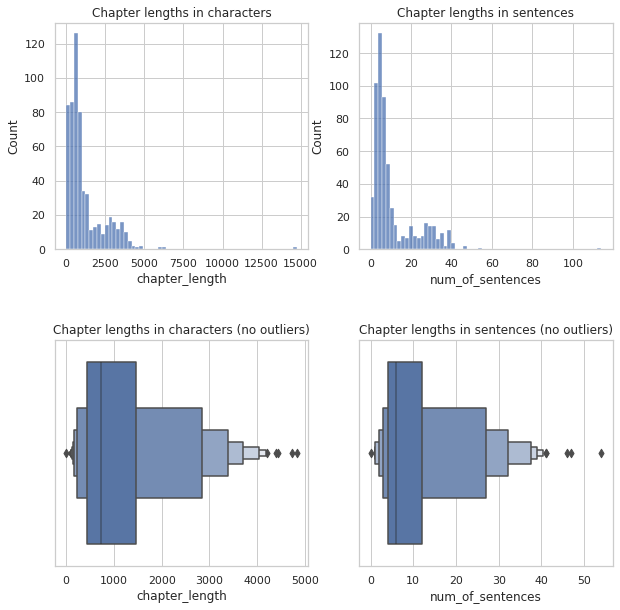

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

fig.add_subplot(2,2, 1)
sns.histplot(df_chapters.chapter_length)
plt.title("Chapter lengths in characters")

fig.add_subplot(2,2, 3)
sns.boxenplot(df_chapters.chapter_length[df_chapters.chapter_length<5000])
plt.title("Chapter lengths in characters (no outliers)")


fig.add_subplot(2,2, 2)
sns.histplot(df_chapters.num_of_sentences)
plt.title("Chapter lengths in sentences")

fig.add_subplot(2,2, 4)
sns.boxenplot(df_chapters.num_of_sentences[df_chapters.num_of_sentences<60])
plt.title("Chapter lengths in sentences (no outliers)")

plt.show()

The average chapter length is around 700 characters total. One chapters is very long. Almost all chapters have no more than 4000 characters.

## Average sentence length

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


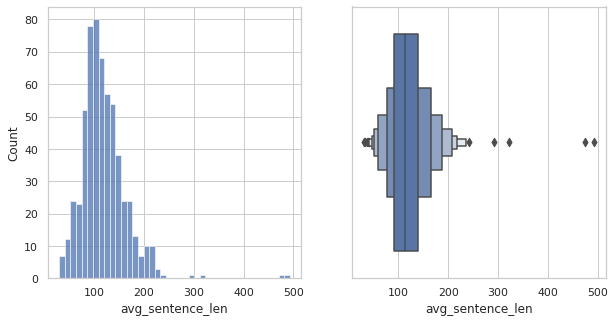

In [ ]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2, 1)
sns.histplot(df_chapters.avg_sentence_len)

fig.add_subplot(1,2, 2)
sns.boxenplot(df_chapters.avg_sentence_len)
plt.show()

The average sentence length per chapter is around 110 characters total. A few chapters have much higher average. Almost all chapters have an average sentence lenght lower than 200 characters.

## Avg sentence length VS Avg chapter length 

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


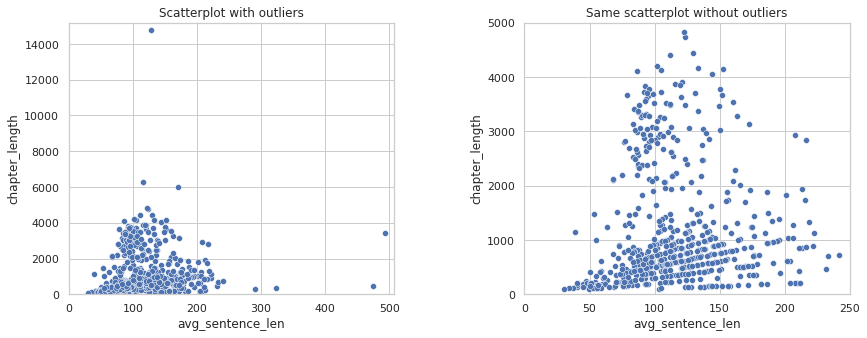

In [ ]:
fig = plt.figure(figsize=(14, 5))
plt.subplots_adjust(wspace=0.4)
fig.add_subplot(1,2, 1)

sns.scatterplot(x=df_chapters.avg_sentence_len, y=df_chapters.chapter_length)
plt.title("Scatterplot with outliers")
plt.ylim(0,np.max(df_chapters.chapter_length)*1.03)
plt.xlim(0,np.max(df_chapters.avg_sentence_len)*1.03)

fig.add_subplot(1,2, 2)
sns.scatterplot(x=df_chapters.avg_sentence_len, 
                y=df_chapters.chapter_length)
plt.title("Same scatterplot without outliers")
plt.ylim(0,5000)
plt.xlim(0,250)
plt.show()

Here, 2 clusters of points are visible - first is a cloud of points where chapter length is above 2000 characters and second cluster is at the bottom. The second one has points arranged in a few horizontal lines - is it a coincidence?

## Avg sentence length VS Number of sentences

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


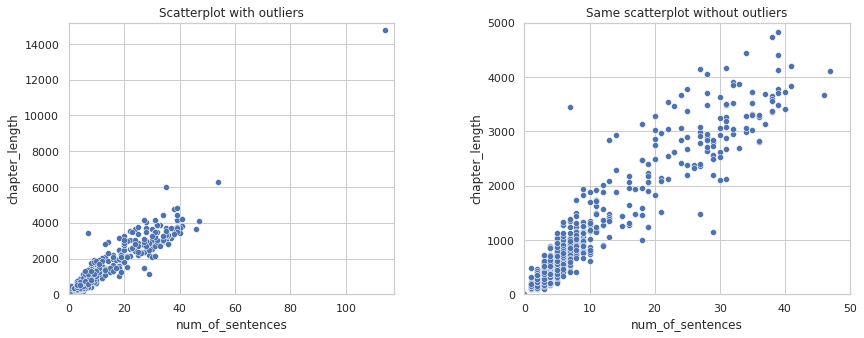

In [ ]:
fig = plt.figure(figsize=(14, 5))
plt.subplots_adjust(wspace=0.4)
fig.add_subplot(1,2, 1)

sns.scatterplot(x=df_chapters.num_of_sentences, y=df_chapters.chapter_length)
plt.title("Scatterplot with outliers")
plt.ylim(0,np.max(df_chapters.chapter_length)*1.03)
plt.xlim(0,np.max(df_chapters.num_of_sentences)*1.03)

fig.add_subplot(1,2, 2)
sns.scatterplot(x=df_chapters.num_of_sentences, 
                y=df_chapters.chapter_length)
plt.title("Same scatterplot without outliers")
plt.ylim(0,5000)
plt.xlim(0,50)
plt.show()

Nothing interesting here. Only thing to notice is that 1 chapter was extremely long.

## Average words length
Here we analyze length of words. For this we use the package **textstat** and we define a few functions.

In [ ]:
import textstat

In [ ]:
# https://github.com/shivam5992/textstat#lexicon-count 

def avg_word_length_for_chapter(chapter):
    words = chapter.split()
    if len(words) == 0:
        return
    return sum(len(word) for word in words) / len(words)

def avg_word_lengths(array_of_text):
    avg_lengths = []
    for chapter in array_of_text:
        avg_lengths.append(avg_word_length_for_chapter(chapter))
    return avg_lengths

# count of words in one chapter
def word_count(chapter):
    return textstat.lexicon_count(chapter, removepunct=True)

# count of words in chapters
def word_counts(chapters):
    count_array = []
    for chapter in chapters:
        count_array.append(word_count(chapter))
    return count_array


# array for every chapter:
avg_array = avg_word_lengths(chapters)
count_array = word_counts(chapters)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can visualize it.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


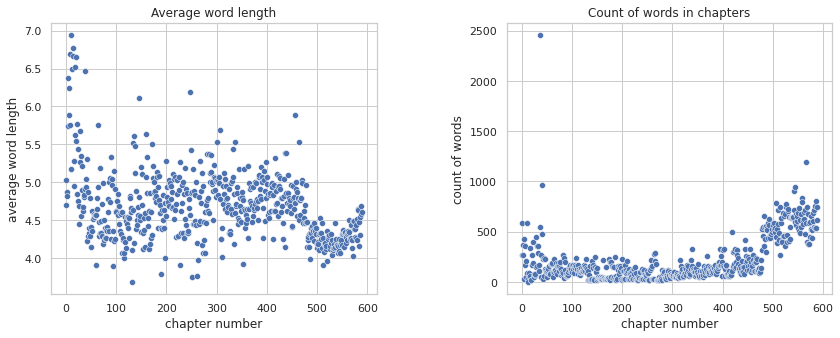

In [ ]:
fig = plt.figure(figsize=(14, 5))
plt.subplots_adjust(wspace=0.4)

fig.add_subplot(1,2, 1)
sns.scatterplot(x=range(len(avg_array)), y=avg_array)
plt.title("Average word length")
plt.xlabel("chapter number")
plt.ylabel("average word length")

fig.add_subplot(1,2, 2)
sns.scatterplot(x=range(len(count_array)), y=count_array)
plt.title("Count of words in chapters")
plt.xlabel("chapter number")
plt.ylabel("count of words")


plt.show()

Interesting - the further the chapter, the average word length decreases, but the number of words increases. Then let's take a look at this relationship.

## Avg words length VS Count of words

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


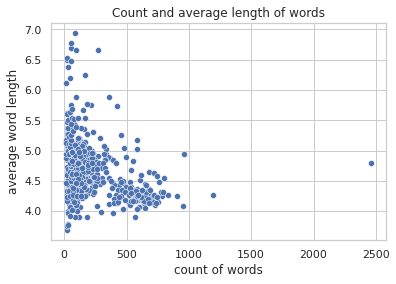

In [ ]:
sns.scatterplot(x=count_array, y=avg_array)
plt.title("Count and average length of words")
plt.xlabel("count of words")
plt.ylabel("average word length")
plt.show()

It seems that the most chapters are relatively short (up to 700 words) and short words (up to 5.5 letters).

## Word clouds

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


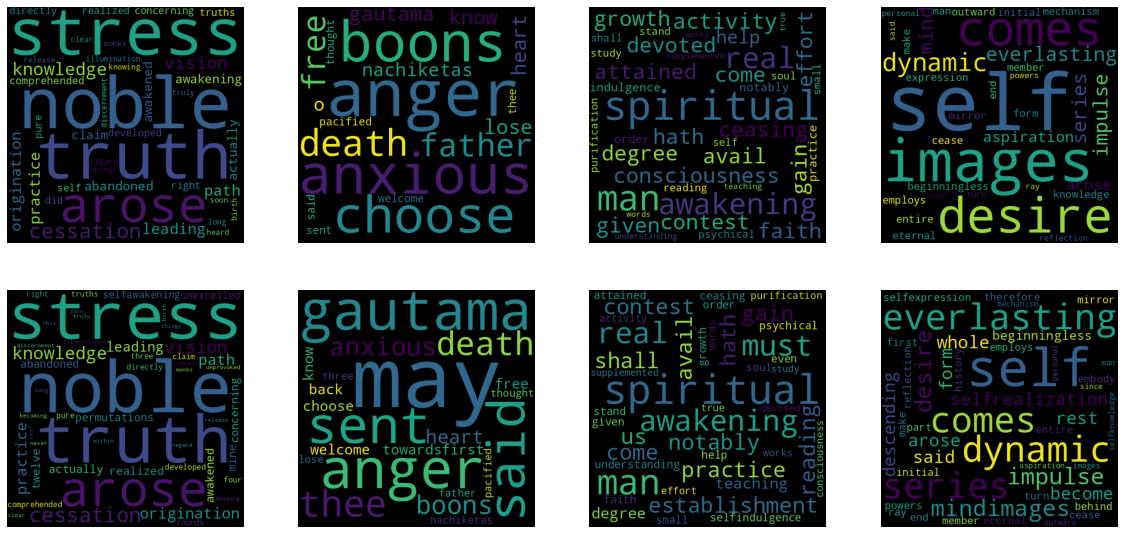

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(3, 590, 150):
    fig.add_subplot(4, 4, i/140+1)
    wordcloud = WordCloud(width=500, height=500, max_words=100, random_state=89)
    plt.imshow(wordcloud.generate_from_frequencies(df_txt.iloc[i,:]))
    plt.axis('off')

    fig.add_subplot(4, 4, i/140+5)
    wordcloud = WordCloud(width=500, height=500, max_words=100, random_state=89)
    plt.imshow(wordcloud.generate_from_frequencies(df_csv.iloc[i,:]))
    plt.axis('off')

plt.show()

Wordclouds comparison for 4 random chapters:
- First row - chapter data from our BoW.
- Second row - chapter data from provided BoW.

Result - some wordclouds are slightly different, others are visibly different.


## Most common words
In this section we can see top 10 the most popular words occuring in the text.

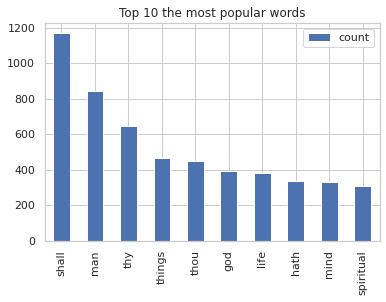

In [ ]:
# TXT
counted_df = pd.DataFrame(df_txt.sum(axis=0, skipna=True), columns=["count"])
counted_df = counted_df.sort_values(by="count", ascending=False).iloc[0:10,]
counted_df.plot(kind="bar", title="Top 10 the most popular words")
plt.show()

Admittedly, the most used words is `shall`, which suggests that in the text there is a lot of advice or injunctions. High frequency of occurrence of the word `man` indicates that the text focuses largely on the human being and very often (frequency of `thy`) addresses the reader directly.

Otherwise, we can read the text is also about `god`, `life` and `spiritual`ity.

And let's compare these results with the already processed texts provided in CSV BoW.

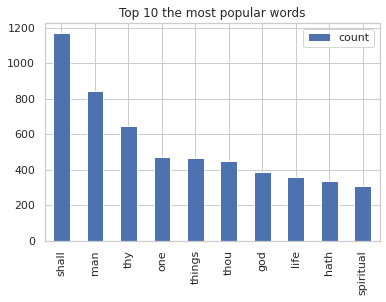

In [ ]:
# CSV
counted_df = pd.DataFrame(df_csv.sum(axis=0, skipna=True), columns=["count"])
counted_df = counted_df.sort_values(by="count", ascending=False).iloc[0:10,]
counted_df.plot(kind="bar", title="Top 10 the most popular words")
plt.show()

We have here very similar situation. Interesting that instead of `things` we have `one` word.

## LDA - topic modelling with Latent Dirichlet Allocation

In [ ]:
def preprocess(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for chapter in df.raw_chapter:
        words=[w.lower() for w in word_tokenize(chapter) if (w.lower() not in set(stopwords.words('english')))]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus
corpus=preprocess(df_chapters)
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 8, 
                                   id2word = dic,  batch=True,                               
                                   passes = 10,   iterations = 500,
                                   workers = None, random_state=47)

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.202406 -0.025651       1        1  32.705890
5     -0.141815 -0.020799       2        1  17.302443
3      0.086716  0.120351       3        1  13.510015
0     -0.127938 -0.023363       4        1   9.137856
4      0.092666  0.050362       5        1   8.773168
7      0.162912 -0.204903       6        1   8.765842
6      0.037354  0.044854       7        1   5.978510
2      0.092511  0.059150       8        1   3.826276, topic_info=           Term         Freq        Total Category  logprob  loglift
2138        thy   569.000000   569.000000  Default  30.0000  30.0000
1296      shall  1131.000000  1131.000000  Default  29.0000  29.0000
2137       thou   395.000000   395.000000  Default  28.0000  28.0000
2331  spiritual   281.000000   281.000000  Default  27.0000  27.0000
1           ...   271.000000   271.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
121       thing     9.138959   489.613753   Topic8  -5.5349  -0.7178
33         know     8.238756   216.413966   Topic8  -5.6386  -0.0051
334       water     7.652430   113.610144   Topic8  -5.7124   0.5655
494         eye     7.610304   127.639916   Topic8  -5.7180   0.4436
324       earth     7.144432   117.766183   Topic8  -5.7811   0.4609

[610 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         1  0.114016    ...
1         2  0.110338    ...
1         4  0.062525    ...
1         5  0.051491    ...
1         6  0.614215    ...
...     ...       ...    ...
85        8  0.066564  would
780       1  0.138294  wrong
780       2  0.082977  wrong
780       4  0.082977  wrong
780       7  0.691472  wrong

[1523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 1, 5, 8, 7, 3])

Circles above represent topics and some magical distance between them is presented on the left panel.

Clicking on a circle will lock selection and then you can hover over most important terms. For example, find a circle which has a word `lord` or `soul` and hover over this word. Circles will change sizes appropriately to importance of the word `lord` or `soul` in their topics.

Similarly, words `monk` and `greed`  seem to have greatly varying importance in different topics. Feel free to check some words on your own! 

We chose the number of topics to find as 8 because there were originally 8 books (therefore plot above is using unavailable data ;P) but the results (circles) are not well separated. It means that the model failed to find 8 different topics. It may be caused by chapters sharing topics - in other situations, where data were for example about war, animals and cooking, we would see 3 clearly separated circles. 

## Text complexity 

Will be computed using FRE - [wikipedia page](https://en.wikipedia.org/wiki/Flesch–Kincaid_readability_tests#Flesch_reading_ease). (lower means harder to read)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


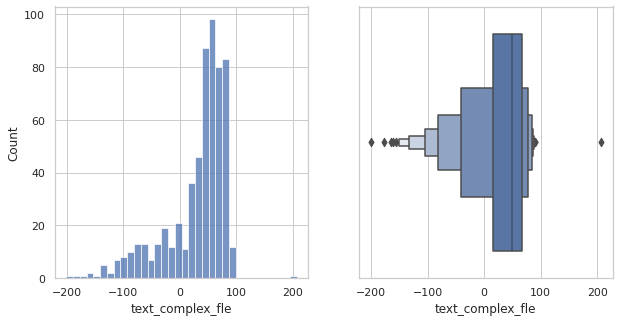

In [ ]:
from textstat import flesch_reading_ease
df_chapters["text_complex_fle"] = df_chapters.raw_chapter.apply(lambda x : flesch_reading_ease(x))

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2, 1)
sns.histplot(df_chapters.text_complex_fle)

fig.add_subplot(1,2, 2)
sns.boxenplot(df_chapters.text_complex_fle)
plt.show()

What is that point on the right!? Well...

FRE = 206.835 − 1.015 * (total words/total sentences) − 84.6 \* (total syllables/ total words).

When a text is empty (one such chapter was found in the beginning of this EDA), the FRE is equal to 206.835. Plots without this chapter are below:

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


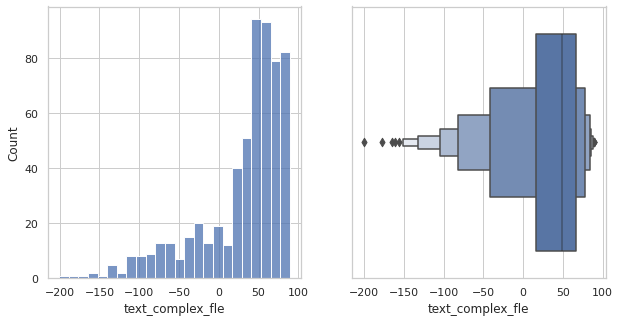

In [ ]:
data = df_chapters.text_complex_fle[df_chapters.text_complex_fle<200]

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1,2, 1)
sns.histplot(data)

fig.add_subplot(1,2, 2)
sns.boxenplot(data)
plt.show()

Most chapters are around 50 - US school level necessary to understand this text is between college and 10th to 12th grade. Many chapters are below 0, where description for scores 0-10 is "Professional - Extremely difficult to read". Is it true?

These texts are not typical texts from newspapers or documents. Instead, they are religious texts with many long words and sentences therefore modern metrics created for modern texts are not applicable to these old texts. (Although these texts are in English translations, they are styled to be older and use many rarely used words.)

## Positive and negative tinting of the text
Here we explore indicator of our text. We define necessary functions.


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def chapter_score(chapter):
    sia = SentimentIntensityAnalyzer()
    sentiment_dict = sia.polarity_scores(chapter)
  
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        return 'Positive'
  
    elif sentiment_dict['compound'] <= - 0.05 :
        return "Negative"
  
    else :
        return "Neutral"

def chapters_score(chapters):
    score_array = []
    for chapter in chapters:
        score_array.append(chapter_score(chapter))
    return score_array

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Helpful source: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [ ]:
# array of tinting of every chapter
score_array = chapters_score(chapters)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


And of course we can visualize it.

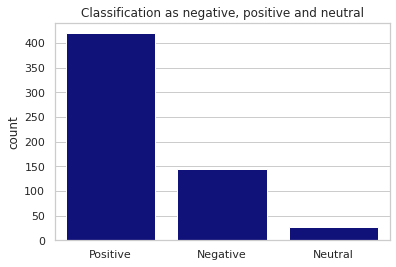

In [ ]:
import seaborn as sns
sns.countplot(score_array, color="darkblue")
plt.title("Classification as negative, positive and neutral")
plt.show()

In line with our intuition, the text is positive, in general. 

## Part of speech analysis
Now, let's take a look at parts of speech. We use **nltk** package.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# downloading necessary
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

For each word we assign a corresponding name of part of speech in English. To understand it better, we can look at an example (first chapter analysis).

In [ ]:
# https://realpython.com/nltk-nlp-python/
words_in_sagan_quote = word_tokenize(chapters[0])
nltk.pos_tag(words_in_sagan_quote)

[('The', 'DT'),
 ('Buddha', 'NNP'),
 (':', ':'),
 ('``', '``'),
 ('What', 'WP'),
 ('do', 'VBP'),
 ('you', 'PRP'),
 ('think', 'VB'),
 (',', ','),
 ('Rahula', 'NNP'),
 (':', ':'),
 ('What', 'WP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('mirror', 'NN'),
 ('for', 'IN'),
 ('?', '.'),
 ('``', '``'),
 ('The', 'DT'),
 ('Buddha', 'NNP'),
 (':', ':'),
 ('Rahula', 'NN'),
 (':', ':'),
 ('``', '``'),
 ('For', 'IN'),
 ('reflection', 'NN'),
 (',', ','),
 ('sir', 'NN'),
 ('.', '.'),
 ('``', '``'),
 ('Rahula', 'NN'),
 (':', ':'),
 ('The', 'DT'),
 ('Buddha', 'NNP'),
 (':', ':'),
 ('``', '``'),
 ('In', 'IN'),
 ('the', 'DT'),
 ('same', 'JJ'),
 ('way', 'NN'),
 (',', ','),
 ('Rahula', 'NNP'),
 (',', ','),
 ('bodily', 'RB'),
 ('acts', 'VBZ'),
 (',', ','),
 ('verbal', 'JJ'),
 ('acts', 'NNS'),
 (',', ','),
 ('&', 'CC'),
 ('mental', 'JJ'),
 ('acts', 'NNS'),
 ('are', 'VBP'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('done', 'VBN'),
 ('with', 'IN'),
 ('repeated', 'VBN'),
 ('reflection.The', 'NN'),
 ('Buddha', 'NN'),
 (':', ':'),


Now, we can count every type of parts of speech and create a chart.

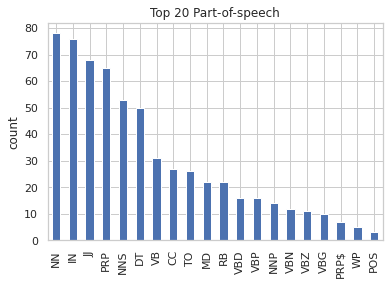

In [ ]:
# https://textblob.readthedocs.io/en/dev/
from textblob import TextBlob

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

blob = TextBlob(str(chapters[0]))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]

pos_df.plot(kind="bar", title = "Top 20 Part-of-speech", ylabel="count")
plt.show()

As we can see, the most popular part of speech is NN, that mainly means `nouns`. That is definitely an advantage, because nouns give dunamism and make the text more pleasant to read and understand.

For those who are more interested we present the list of other types of parts of speech.

**NN**: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...

**IN**: preposition or conjunction, subordinating
    astride among uppon whether out inside pro despite on by throughout
    below within for towards near behind atop around if like until below
    next into if beside ...

**CC**: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
MD: modal auxiliary
    can cannot could couldn't dare may might must need ought shall should
    shouldn't will would

NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...

NNPS: noun, proper, plural
    Americans Americas Amharas Amityvilles Amusements Anarcho-Syndicalists
    Andalusians Andes Andruses Angels Animals Anthony Antilles Antiques
    Apache Apaches Apocrypha ...

NNS: noun, common, plural
    undergraduates scotches bric-a-brac products bodyguards facets coasts
    divestitures storehouses designs clubs fragrances averages
    subjectivists apprehensions muses factory-jobs ...

PDT: pre-determiner
    all both half many quite such sure this

POS: genitive marker
    ' 's

PRP: pronoun, personal
    hers herself him himself hisself it itself me myself one oneself ours
    ourselves ownself self she thee theirs them themselves they thou thy us

PRP$: pronoun, possessive
    her his mine my our ours their thy your

RB: adverb
    occasionally unabatingly maddeningly adventurously professedly
    stirringly prominently technologically magisterially predominately
    swiftly fiscally pitilessly ...

RBR: adverb, comparative
    further gloomier grander graver greater grimmer harder harsher
    healthier heavier higher however larger later leaner lengthier less-
    perfectly lesser lonelier longer louder lower more ...

RBS: adverb, superlative
    best biggest bluntest earliest farthest first furthest hardest
    heartiest highest largest least less most nearest second tightest worst

RP: particle
    aboard about across along apart around aside at away back before behind
    by crop down ever fast for forth from go high i.e. in into just later
    low more off on open out over per pie raising start teeth that through
    under unto up up-pp upon whole with you

SYM: symbol
    % & ' '' ''. ) ). * + ,. < = > @ A[fj] U.S U.S.S.R * ** ***

TO: "to" as preposition or infinitive marker
    to

UH: interjection
    Goodbye Goody Gosh Wow Jeepers Jee-sus Hubba Hey Kee-reist Oops amen
    huh howdy uh dammit whammo shucks heck anyways whodunnit honey golly
    man baby diddle hush sonuvabitch ...

VB: verb, base form
    ask assemble assess assign assume atone attention avoid bake balkanize
    bank begin behold believe bend benefit bevel beware bless boil bomb
    boost brace break bring broil brush build ...

VBD: verb, past tense
    dipped pleaded swiped regummed soaked tidied convened halted registered
    cushioned exacted snubbed strode aimed adopted belied figgered
    speculated wore appreciated contemplated ...

VBG: verb, present participle or gerund
    telegraphing stirring focusing angering judging stalling lactating
    hankerin' alleging veering capping approaching traveling besieging
    encrypting interrupting erasing wincing ...

VBN: verb, past participle
    multihulled dilapidated aerosolized chaired languished panelized used
    experimented flourished imitated reunifed factored condensed sheared
    unsettled primed dubbed desired ...

VBP: verb, present tense, not 3rd person singular
    predominate wrap resort sue twist spill cure lengthen brush terminate
    appear tend stray glisten obtain comprise detest tease attract
    emphasize mold postpone sever return wag ...

VBZ: verb, present tense, 3rd person singular
    bases reconstructs marks mixes displeases seals carps weaves snatches
    slumps stretches authorizes smolders pictures emerges stockpiles
    seduces fizzes uses bolsters slaps speaks pleads ...

WDT: WH-determiner
    that what whatever which whichever

WP: WH-pronoun
    that what whatever whatsoever which who whom whosoever

WP$: WH-pronoun, possessive
    whose

WRB: Wh-adverb
    how however whence whenever where whereby whereever wherein whereof why

# Summary

These are the results:
- scatterplot "Avg sentence length VS Avg chapter length" can give a clue about dividing 590 chapters in 2 groups,
- scatterplot "Avg words length VS Count of words" also suggests that there exists at least 2 clusters of chapter,
- all texts have similar topics as shown in topis analysis section and section about most common words,
- most chapters are rather positive however some are neutral or negative (in terms of tinting of the text).

To present more plots we created some of them based on raw txt file (preprocessed by us). Comparison between the preprocessed BoW and our version of BoW created (from raw texts from txt file) got us some results too:
- wordclouds have slight differences,
- common words from both sources of data are very similar.

Overall our BoW is similar to the original BoW except is does contain words present in at least 2 chapters (the original BoW has many words which can be found in 1 chapter only).

Side note: One of the chapters is empty so classifying it "correctly" makes no sense. (chapter 14 of Buddha Sutras)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dec29cf4-92ce-44ce-abbe-50ee753aee6f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>